In [1]:
##加载模型
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import random
import json
from tqdm import tqdm
from bleurt import score
import tensorflow as tf
import os
from rouge import Rouge 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 或者 tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')


# BLEURT指标
BLEURT（Bilingual Evaluation Understudy with Representations from Transformers）是一种用于评估自然语言生成任务，如机器翻译、文本摘要等的指标。它是在BLEU的基础上发展起来的，使用了Transformer模型（如BERT）的表示来更准确地评估生成文本的质量。

具体来说，BLEURT首先使用预训练的Transformer模型来获取生成文本和参考文本的表示，然后比较这些表示来计算分数。这种方法可以捕获文本的深层语义信息，因此比基于n-gram匹配的BLEU更准确。

总的来说，BLEURT是一种更先进、更准确的自然语言生成评估指标。

## 注意在读取文件时需要读取cut前后的全集，即包含分割前一部分的文本

In [3]:
with open('cosine_sum_similarity1_4.json','r',encoding='utf-8') as f:
    # data = f.read()
    compressed_output = json.load(f)
print(len(compressed_output))    

1617


In [4]:
scorer = score.BleurtScorer("bleurt/bleurt/test_checkpoint")
bleu_output = []
for i, item in (enumerate(tqdm(compressed_output))):
    # if len(item['text']) == 0:
        # compressed_output.pop(i)
    item2 = {}
    item2['input'] = item['input']
    item2['output'] = item['output']
    item2['label'] = item['label']
    item2['BLEURT_score'] = scorer.score(references=[item['input']], candidates=[item['output']])[0]
    bleu_output.append(item2)

100%|██████████| 1617/1617 [00:24<00:00, 66.87it/s]


In [5]:
with open('bleu_output.json', 'w', encoding='utf-8') as f:
    json.dump(bleu_output, f, ensure_ascii=False, indent=4)

In [7]:
from sklearn.metrics import roc_auc_score
labels = [1 if item['label'] == 'dirty' else 0 for item in bleu_output]
bleu_scores = [item['BLEURT_score'] for item in bleu_output]
auc_score = roc_auc_score( labels,bleu_scores)
print(f"AUC: {auc_score.item()}")

AUC: 0.4867502355921624


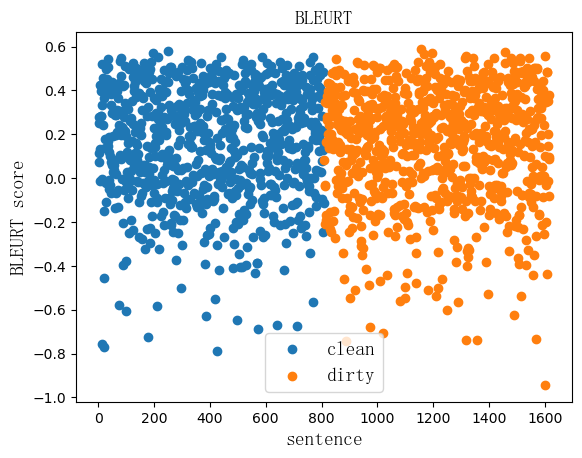

In [24]:

import matplotlib.pyplot as plt
import json
from matplotlib.font_manager import FontProperties
import numpy as np

# 指定字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

# 加载你的数据
with open('bleu_output.json','r',encoding='utf-8') as f:
    data = json.load(f)

# 将数据分为cl
sequence_score = [item['BLEURT_score'] for item in data]
labels = [item['label'] for item in data]  # 获取所有的标签

# 获取所有的唯一标签
unique_labels = list(set(labels))

# 创建横坐标值
items = np.arange(1, len(sequence_score) + 1)

# 对于每个唯一的标签，绘制一个散点图
for label in unique_labels:
    # 获取这个标签的所有分数
    label_scores = [sequence_score[i] for i in range(len(sequence_score)) if labels[i] == label]
    # 获取这个标签的所有项
    label_items = [items[i] for i in range(len(items)) if labels[i] == label]
    # 绘制散点图
    plt.scatter(label_items, label_scores, label=label)

# 在0.25处添加一条基线
# plt.axhline(y=0.25, color='r', linestyle='--')

plt.xlabel('sentence', fontproperties=font)
plt.ylabel('BLEURT score', fontproperties=font)
plt.title('BLEURT', fontproperties=font)
plt.legend(prop=font)

plt.show()

# ROUGE指标
ROUGE（Recall-Oriented Understudy for Gisting Evaluation）是一种用于评估自动文本摘要的指标。它通过比较自动生成的摘要和人工编写的参考摘要来计算分数。

ROUGE有多种变体，包括：

ROUGE-N：比较n-gram的重叠。例如，ROUGE-1比较单个词的重叠，ROUGE-2比较两个词的短语的重叠。

ROUGE-L：比较最长公共子序列（LCS）。LCS是两个序列中最长的一段连续的共享序列。

ROUGE-S：比较任意顺序的词对的重叠。

总的来说，ROUGE是一种评估自动文本摘要质量的常用指标。

## 注意在读取文件时需要读取cut前后的子集，即不包含分割前一部分的文本，区别于上一步

In [2]:
with open('compressed_output.json','r',encoding='utf-8') as f:
    # data = f.read()
    compressed_output = json.load(f)
print(len(compressed_output))    

1617


In [3]:
def get_skip_bigrams(text, skip=2):
    """
    获取文本中的skip-bigrams
    """
    tokens = text.split()
    skip_bigrams = [(tokens[i], tokens[i+skip]) for i in range(len(tokens)-skip)]
    return set(skip_bigrams)

def rouge_s(generated_text, reference_text, skip=2):
    """
    计算ROUGE-S分数
    """
    generated_bigrams = get_skip_bigrams(generated_text, skip)
    reference_bigrams = get_skip_bigrams(reference_text, skip)

    overlap = generated_bigrams.intersection(reference_bigrams)

    precision = len(overlap) / len(generated_bigrams) if generated_bigrams else 0
    recall = len(overlap) / len(reference_bigrams) if reference_bigrams else 0

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return {"precision": precision, "recall": recall, "f1_score": f1_score}

In [4]:
# scorer = score.BleurtScorer("bleurt/bleurt/test_checkpoint")
# 初始化 ROUGE scorer
rouge = Rouge()
# # 测试
# generated_text = "我 爱 编 程 "
# reference_text = "我 爱 阅 读 编 程"
# 你的代码看起来是正确的，但是在计算ROUGE分数时，你需要确保你的文本是以空格分隔的词的序列。
# rouge库在计算ROUGE分数时，会将文本分割成单词，然后计算这些单词的重叠。如果你的文本没有用空格分隔，
# 那么rouge库可能会将整个文本视为一个单词，导致计算出的ROUGE分数为0。
# 计算 ROUGE-L 分数
# scores = rouge.get_scores(generated_text, reference_text)
rouge_output = []
for i, item in (enumerate(tqdm(compressed_output))):
    # if len(item['text']) == 0:
        # compressed_output.pop(i)
    item2 = {}
    item2['input'] = item['input']
    item2['output'] = item['output']
    item2['label'] = item['label']
    try:
        item2['ROUGE_1_score'] = rouge.get_scores([item['output']],[item['input']])[0]['rouge-1']['f']
        item2['ROUGE_2_score'] = rouge.get_scores([item['output']],[item['input']])[0]['rouge-2']['f']
        item2['ROUGE_L_score'] = rouge.get_scores([item['output']],[item['input']])[0]['rouge-l']['f']        
    except:
        item2['ROUGE_1_score'] = 0
        item2['ROUGE_2_score'] = 0
        item2['ROUGE_L_score'] = 0
    try:
        item2['ROUGE_S1_score'] = rouge_s(item['output'], item['input'], skip=1)['f1_score']
        item2['ROUGE_S2_score'] = rouge_s(item['output'], item['input'], skip=2)['f1_score']
    except:
        item2['ROUGE_S1_score'] = 0
        item2['ROUGE_S2_score'] = 0    
    rouge_output.append(item2)


100%|██████████| 1617/1617 [04:41<00:00,  5.74it/s]


In [5]:
with open('rouge_output.json', 'w', encoding='utf-8') as f:
    json.dump(rouge_output, f, ensure_ascii=False, indent=4)

In [6]:
from sklearn.metrics import roc_auc_score
labels = [1 if item['label'] == 'dirty' else 0 for item in rouge_output]
rouge_1_scores = [item['ROUGE_1_score'] for item in rouge_output]
auc_1_score = roc_auc_score( labels,rouge_1_scores)
print(f"AUC_ROUGE_1: {auc_1_score.item()}")
rouge_2_scores = [item['ROUGE_2_score'] for item in rouge_output]
auc_2_score = roc_auc_score( labels,rouge_2_scores)
print(f"AUC_ROUGE_2: {auc_2_score.item()}")
rouge_l_scores = [item['ROUGE_L_score'] for item in rouge_output]
auc_l_score = roc_auc_score( labels,rouge_l_scores)
print(f"AUC_ROUGE_L: {auc_l_score.item()}")
rouge_s1_scores = [item['ROUGE_S1_score'] for item in rouge_output]
auc_s1_score = roc_auc_score( labels,rouge_s1_scores)
print(f"AUC_ROUGE_S1: {auc_s1_score.item()}")
rouge_s2_scores = [item['ROUGE_S2_score'] for item in rouge_output]
auc_s2_score = roc_auc_score( labels,rouge_s2_scores)
print(f"AUC_ROUGE_S2: {auc_s1_score.item()}")

AUC_ROUGE_1: 0.4929964875350329
AUC_ROUGE_2: 0.5038995092339889
AUC_ROUGE_L: 0.4945982082757101
AUC_ROUGE_S1: 0.5006593520909569
AUC_ROUGE_S2: 0.5006593520909569


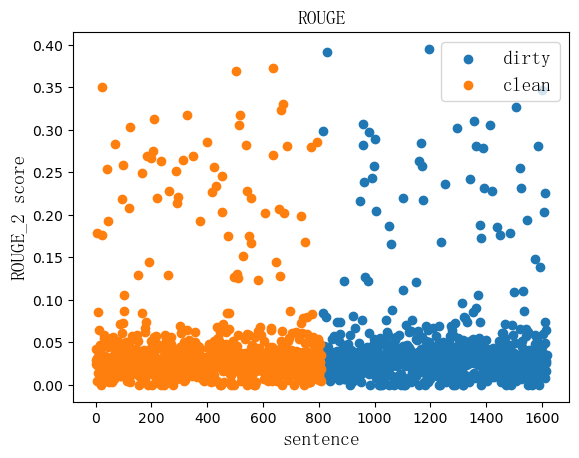

In [7]:

import matplotlib.pyplot as plt
import json
from matplotlib.font_manager import FontProperties
import numpy as np

# 指定字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

# 加载你的数据
with open('rouge_output.json','r',encoding='utf-8') as f:
    data = json.load(f)

# 将数据分为cl
sequence_score = [item['ROUGE_2_score'] for item in data]
labels = [item['label'] for item in data]  # 获取所有的标签

# 获取所有的唯一标签
unique_labels = list(set(labels))

# 创建横坐标值
items = np.arange(1, len(sequence_score) + 1)

# 对于每个唯一的标签，绘制一个散点图
for label in unique_labels:
    # 获取这个标签的所有分数
    label_scores = [sequence_score[i] for i in range(len(sequence_score)) if labels[i] == label]
    # 获取这个标签的所有项
    label_items = [items[i] for i in range(len(items)) if labels[i] == label]
    # 绘制散点图
    plt.scatter(label_items, label_scores, label=label)

# 在0.25处添加一条基线
# plt.axhline(y=0.25, color='r', linestyle='--')

plt.xlabel('sentence', fontproperties=font)
plt.ylabel('ROUGE_2 score', fontproperties=font)
plt.title('ROUGE', fontproperties=font)
plt.legend(prop=font)

plt.show()